In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
import scipy.interpolate as interpolate
import IPython
from google.colab import files

from copy import  copy
from sklearn.preprocessing import KBinsDiscretizer
import networkx as nx
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
!pip install pgmpy
!pip install pomegranate
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG
from pomegranate import *

#!pip install graphviz

!sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
!sudo pip install pygraphviz


#!pip install pygraphviz 


Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
python-dev is already the newest version (2.7.15~rc1-1).
graphviz is already the newest version (2.40.1-2).
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
libgraphviz-dev is already the newest version (2.40.1-2).
python3-dev is already the newest version (3.6.7-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!git clone https://github.com/ITMO-NSS-team/BAMT.git

%cd BAMT

# install packages requirements
!pip install -r requirements.txt

fatal: destination path 'BAMT' already exists and is not an empty directory.
/content/BAMT


In [ ]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [ ]:
%cd BAMT

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

[Errno 2] No such file or directory: 'BAMT'
/content/BAMT


/content/BAMT/external/libpgm/hybayesiannetwork.py:120: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert ((isinstance(n, int) and n > 0), "Argument must be a positive integer.")
/content/BAMT/external/libpgm/hybayesiannetwork.py:143: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (pvalue != 'default', "Graph skeleton was not topologically ordered.")


In [ ]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/onehr.data', names=['Date' ,'WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23', 'WSR_PK', 'WSR_AV', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T_PK', 'T_AV', 'T85', 'RH85', 'U85', 'V85', 'HT85', 'T70', 'RH70', 'U70', 'V70', 'HT70', 'T50', 'RH50', 'U50', 'V50', 'HT50', 'KI', 'TT', 'SLP', 'SLP_', 'Precp', 'Ozone'])
non_date_columns = [col for col in data.columns if col != 'Date']
data[non_date_columns] = data[non_date_columns].replace('?', np.nan).astype(np.float32)
data.dropna(inplace=True)
data

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,WSR10,WSR11,WSR12,WSR13,WSR14,WSR15,WSR16,WSR17,WSR18,WSR19,WSR20,WSR21,WSR22,WSR23,WSR_PK,WSR_AV,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,RH70,U70,V70,HT70,T50,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Ozone
0,1/1/1998,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,3.7,5.5,5.1,5.4,5.4,4.7,4.3,3.5,3.5,2.9,3.2,3.2,2.8,2.6,5.5,3.1,5.200000,6.100000,6.100000,6.100000,6.100000,5.600000,5.200000,5.400000,7.200000,10.600000,14.500000,17.200001,18.299999,18.900000,19.100000,18.900000,18.299999,17.299999,16.799999,16.100000,15.400000,14.900000,14.800000,15.000000,19.100000,12.500000,6.7,0.11,3.83,0.14,1612.0,-2.3,0.30,7.18,0.12,3178.5,-15.500000,0.15,10.67,-1.56,5795.0,-12.10,17.900000,10330.0,-55.0,0.00,0.0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,4.2,4.5,4.5,4.3,5.5,5.1,3.8,3.0,2.6,3.0,2.2,2.3,2.5,2.8,5.5,3.4,15.100000,15.300000,15.600000,15.600000,15.900000,16.200001,16.200001,16.200001,16.600000,17.799999,19.400000,20.600000,21.200001,21.799999,22.400000,22.100000,20.799999,19.100000,18.100000,17.200001,16.500000,16.100000,16.000000,16.200001,22.400000,17.799999,9.0,0.25,-0.41,9.53,1594.5,-2.2,0.96,8.24,7.30,3172.0,-14.500000,0.48,8.39,3.84,5805.0,14.05,29.000000,10275.0,-55.0,0.00,0.0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,3.1,4.0,4.4,4.6,5.6,5.4,5.2,4.4,3.5,2.7,2.9,3.9,4.1,4.6,5.6,3.5,16.600000,16.700001,16.700001,16.799999,16.799999,16.799999,16.900000,16.900000,17.100000,17.600000,19.100000,21.299999,21.799999,22.000000,22.100000,22.200001,21.299999,19.799999,18.600000,18.000000,18.000000,18.200001,18.299999,18.400000,22.200001,18.700001,9.0,0.56,0.89,10.17,1568.5,0.9,0.54,3.80,4.42,3160.0,-15.900000,0.60,6.94,9.80,5790.0,17.90,41.299999,10235.0,-40.0,0.00,0.0
3,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,3.3,3.1,2.3,2.1,2.2,3.8,2.8,2.4,1.9,3.2,4.1,3.9,4.5,4.3,4.7,3.2,18.299999,18.200001,18.299999,18.400000,18.600000,18.600000,18.500000,18.700001,18.600000,18.799999,19.000000,19.000000,19.299999,19.400000,19.600000,19.200001,18.900000,18.799999,18.600000,18.500000,18.299999,18.500000,18.799999,18.900000,19.600000,18.700001,9.9,0.89,-0.34,8.58,1546.5,3.0,0.77,4.17,8.11,3145.5,-16.799999,0.49,8.73,10.54,5775.0,31.15,51.700001,10195.0,-40.0,2.08,0.0
6,1/7/1998,3.7,3.2,3.8,5.1,6.0,7.0,6.3,6.4,6.3,5.4,6.1,6.4,6.1,5.8,6.2,6.2,5.5,4.8,5.5,6.1,5.0,3.1,2.2,1.6,7.0,5.2,15.600000,15.600000,15.500000,15.800000,14.700000,12.000000,10.400000,9.000000,8.100000,8.400000,8.800000,8.800000,8.700000,8.600000,8.300000,8.200000,7.800000,7.700000,7.400000,7.300000,7.300000,7.100000,6.600000,5.700000,15.800000,9.700000,12.6,0.98,0.48,7.46,1413.0,4.6,0.53,13.36,15.34,3027.5,-11.800000,0.84,6.86,25.60,5695.0,26.75,48.450001,10040.0,-80.0,0.18,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2531,12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,2.2,2.8,2.8,2.8,3.4,3.9,3.8,3.5,2.0,1.7,1.5,1.3,1.3,1.3,1.1,3.9,1.6,2.800000,2.300000,1.600000,1.200000,1.300000,1.300000,1.200000,1.100000,3.800000,7.600000,10.700000,12.600000,13.900000,14.500000,14.700000,14.800000,14.200000,12.900000,11.300000,9.900000,8.800000,7.900000,7.300000,7.000000,14.800000,7.700000,5.5,0.33,-2.25,-1.92,1576.0,3.2,0.06,0.01,-3.50,3153.5,-12.400000,0.07,7.93,-4.41,5800.0,-25.60,21.799999,10295.0,65.0,0.00,0.0
2532,12/28/2004,1.0,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,2.4,4.2,4.6,4.2,4.8,5.0,4.7,3.7,3.6,2.7,3.1,2.1,1.8,1.6,1.1,5.0,2.6,7.000000,6.900000,7.100000,7.600000,7.700000,7.700000,7.700000,7.800000,9.400000,12.400000,15.500000,17.299999,17.900000,18.400000,18.299999,17.600000,16.900000,15.800000,15.400000,15.100000,15.000000,14.800000,15.100000,15.300000,18.400000,12.900000,5.8,0.27,-2.4

# **Step 1. Choosing variables for sampling from dataset.**

In [ ]:
predictors = data[['T85', 'U70', 'HT50', 'T8', 'T70', 'V85', 'KI']]
target = data[['T_AV', 'T_PK', 'T0']]

#**Step 2. Sampling of chosen target variables.**

# **Inverse Transform Sampling**

In [ ]:
def inverse_transform_sampling(data, n_bins=50, n_samples=1848):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r), bin_edges

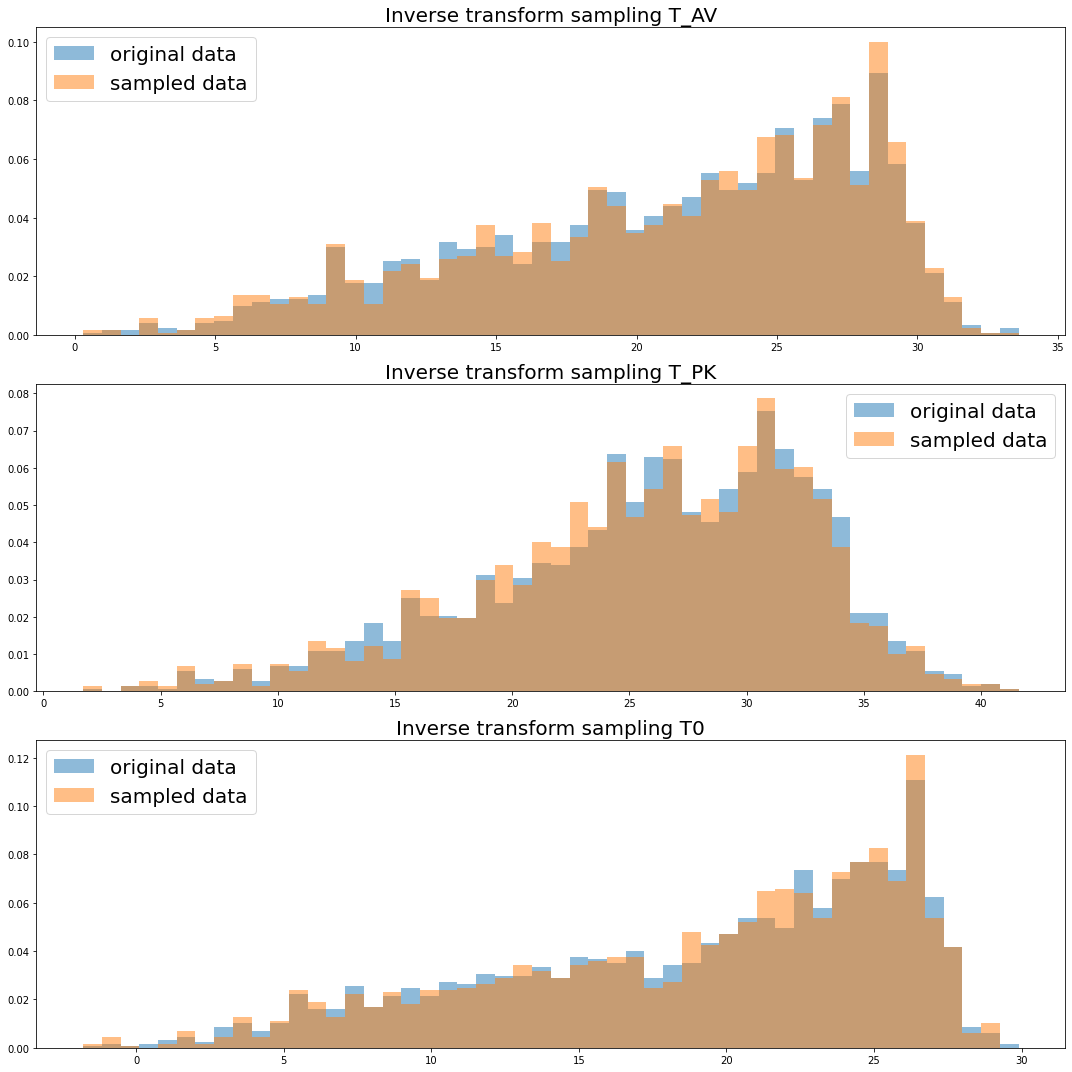

In [ ]:
orig_val_1 = np.array(target[['T_AV']])
inv_cdf_1, bin_edges_1 = inverse_transform_sampling(target[['T_AV']])

orig_val_2 = np.array(target[['T_PK']])
inv_cdf_2, bin_edges_2 = inverse_transform_sampling(target[['T_PK']])

orig_val_3 = np.array(target[['T0']])
inv_cdf_3, bin_edges_3 = inverse_transform_sampling(target[['T0']])

fig, axs = plt.subplots(3, figsize=(15,15))

axs[0].hist(orig_val_1, bin_edges_1, density = True, alpha=0.5, label='original data')
axs[0].hist(inv_cdf_1, bin_edges_1, density = True, alpha=0.5, label='sampled data')
axs[0].legend(loc='best', fontsize=20)
axs[0].set_title('Inverse transform sampling T_AV', fontsize=20)

axs[1].hist(orig_val_2, bin_edges_2, density = True, alpha=0.5, label='original data')
axs[1].hist(inv_cdf_2, bin_edges_2, density = True, alpha=0.5, label='sampled data')
axs[1].legend(loc='best', fontsize=20)
axs[1].set_title('Inverse transform sampling T_PK', fontsize=20)

axs[2].hist(orig_val_3, bin_edges_3, density = True, alpha=0.5, label='original data')
axs[2].hist(inv_cdf_3, bin_edges_3, density = True, alpha=0.5, label='sampled data')
axs[2].legend(loc='best', fontsize=20)
axs[2].set_title('Inverse transform sampling T0', fontsize=20)
plt.tight_layout()

# **Reject Sampling**

In [ ]:
# normal PDF
def g(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def f(candidate, X, Y):
    dist = abs(X[0] - candidate)
    index = 0
    for i in range(len(X) - 1):
        if (abs(X[i] - candidate) < dist):
            dist = abs(X[i] - candidate)
            index = i
    return Y[index] / np.max(Y)

def rejection_sampling(hist_y_1, hist_x_1, N_samples, mean, std, M):
    samples_n = 0
    samples = []
    while samples_n < N_samples:
        # get a candidate from uniform distribution
        candidate = np.random.normal(mean, std)
        if not (candidate > hist_x_1[0] and candidate < hist_x_1[len(hist_x_1) - 1]):
            continue
        # calculate probabailty of accepting this sample
        prob_accept = f(candidate, hist_x_1, hist_y_1) / (M * g(candidate, mean, std))

        # accept sample with this probability
        if np.random.random() < prob_accept:
            samples_n += 1
            samples.append(candidate)
    return samples

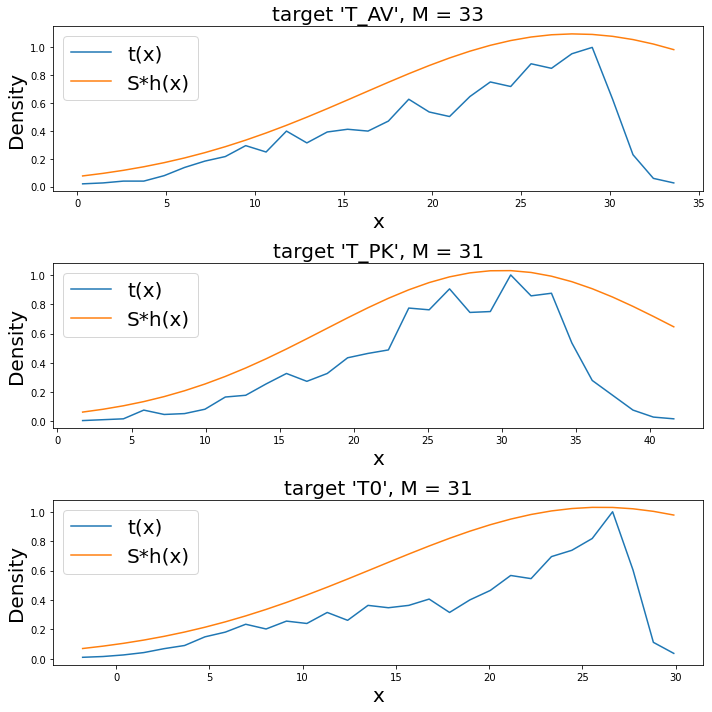

In [ ]:
bins_n = 30

# target 1
M_1 = 33
mean_1 = 28
std_1 = 12

hist_y_1, hist_x_1 = np.histogram(np.array(target[['T_AV']]), bins=bins_n, density=True)
x_1 = np.linspace(hist_x_1[0], hist_x_1[bins_n], bins_n)
eval_vals_1 = g(x_1, mean_1, std_1)

# target 2
M_2 = 31
mean_2 = 30
std_2 = 12

hist_y_2, hist_x_2 = np.histogram(np.array(target[['T_PK']]), bins=bins_n, density=True)
x_2 = np.linspace(hist_x_2[0], hist_x_2[bins_n], bins_n)
eval_vals_2 = g(x_2, mean_2, std_2)

# target 3
M_3 = 31
mean_3 = 26
std_3 = 12

hist_y_3, hist_x_3 = np.histogram(np.array(target[['T0']]), bins=bins_n, density=True)
x_3 = np.linspace(hist_x_3[0], hist_x_3[bins_n], bins_n)
eval_vals_3 = g(x_3, mean_3, std_3)


fig, axs = plt.subplots(3, figsize=(10,10))

axs[0].plot(x_1, hist_y_1/np.max(hist_y_1))
axs[0].plot(x_1, M_1*eval_vals_1)
axs[0].set_xlabel('x', fontsize=20)
axs[0].set_ylabel('Density', fontsize=20)
axs[0].legend(['t(x)', 'S*h(x)'], fontsize=20, loc='best')
axs[0].set_title('target \'T_AV\', M = 33', fontsize=20)

axs[1].plot(x_2, hist_y_2/np.max(hist_y_2))
axs[1].plot(x_2, M_2*eval_vals_2)
axs[1].set_xlabel('x', fontsize=20)
axs[1].set_ylabel('Density', fontsize=20)
axs[1].legend(['t(x)', 'S*h(x)'], fontsize=20, loc='best')
axs[1].set_title('target \'T_PK\', M = 31', fontsize=20)

axs[2].plot(x_3, hist_y_3/np.max(hist_y_3))
axs[2].plot(x_3, M_3*eval_vals_3)
axs[2].set_xlabel('x', fontsize=20)
axs[2].set_ylabel('Density', fontsize=20)
axs[2].legend(['t(x)', 'S*h(x)'], fontsize=20, loc='best')
axs[2].set_title('target \'T0\', M = 31', fontsize=20)
plt.tight_layout()

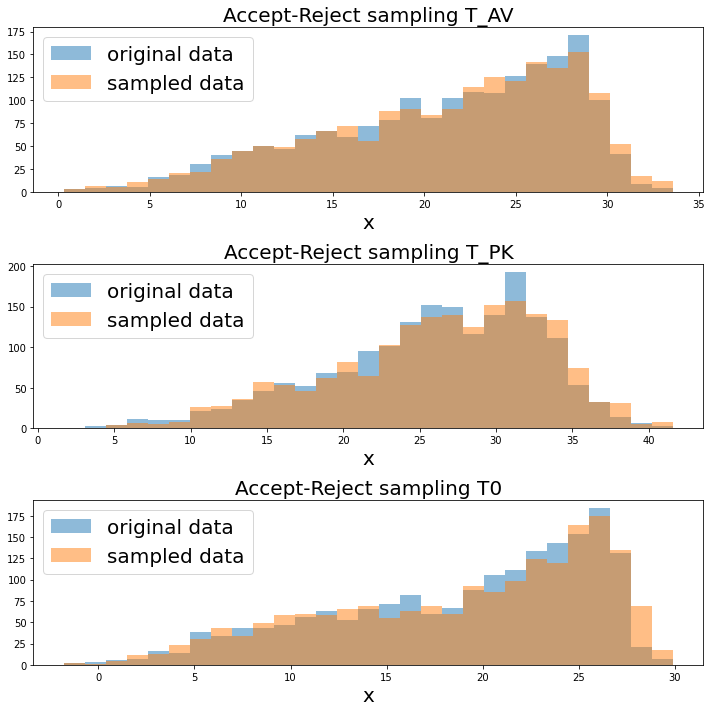

In [ ]:
N_samples = 1848

samples_1 = rejection_sampling(hist_y_1=hist_y_1, hist_x_1=x_1, N_samples=N_samples, mean=mean_1, std=std_1, M=M_1)
samples_2 = rejection_sampling(hist_y_1=hist_y_2, hist_x_1=x_2, N_samples=N_samples, mean=mean_2, std=std_2, M=M_2)
samples_3 = rejection_sampling(hist_y_1=hist_y_3, hist_x_1=x_3, N_samples=N_samples, mean=mean_3, std=std_3, M=M_3)

fig, axs = plt.subplots(3, figsize=(10,10))

axs[0].hist(np.array(target[['T_AV']]), x_1, alpha=0.5, label='original data')
axs[0].hist(samples_1, x_1, alpha=0.5, label='sampled data')
axs[0].legend(loc='best', fontsize=20)
axs[0].set_xlabel('x', fontsize=20)
axs[0].set_title('Accept-Reject sampling T_AV', fontsize=20)

axs[1].hist(np.array(target[['T_PK']]), x_2, alpha=0.5, label='original data')
axs[1].hist(samples_2, x_2, alpha=0.5, label='sampled data')
axs[1].legend(loc='best', fontsize=20)
axs[1].set_xlabel('x', fontsize=20)
axs[1].set_title('Accept-Reject sampling T_PK', fontsize=20)

axs[2].hist(np.array(target[['T0']]), x_3, alpha=0.5, label='original data')
axs[2].hist(samples_3, x_3, alpha=0.5, label='sampled data')
axs[2].legend(loc='best', fontsize=20)
axs[2].set_xlabel('x', fontsize=20)
axs[2].set_title('Accept-Reject sampling T0', fontsize=20)

plt.tight_layout()

# **Step 3. Estimation ralations between predictors and chosen target variables**

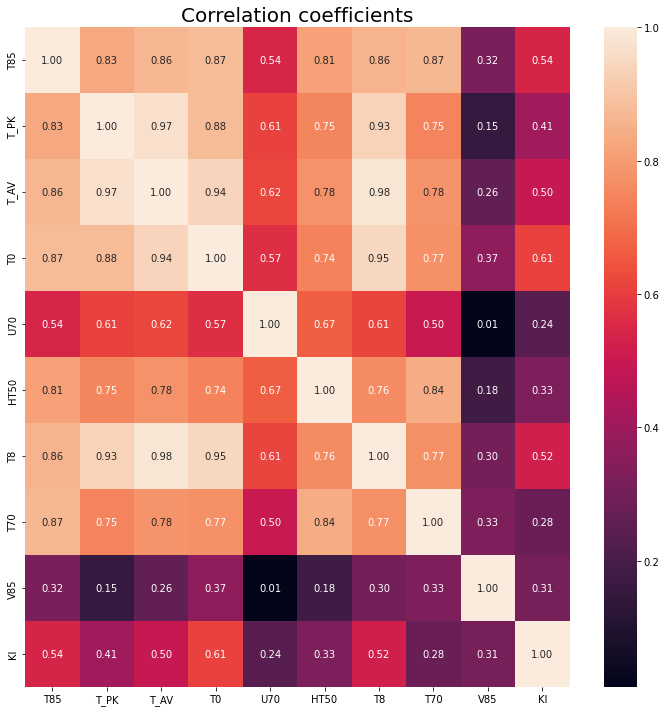

In [ ]:
subsample_names = ['T85', 'T_PK', 'T_AV', 'T0', 'U70', 'HT50', 'T8', 'T70', 'V85', 'KI']
subsample = data[subsample_names]

fig, axs = plt.subplots(figsize=(10,10))
sns.heatmap(abs(subsample.corr()), annot=True, fmt='.2f')
plt.title('Correlation coefficients', fontsize=20)
plt.tight_layout()

# **Step 4. Building a Bayesian network for chosen set of variables. Structure is based on multivariate analysis**

In [ ]:
nodes_type = get_nodes_type(subsample)
nodes_sign = get_nodes_sign(subsample)
discrete_data, coder = discretization(subsample, 'equal_frequency', subsample_names)

In [ ]:
bn = {'V': ['T85', 'T_PK', 'T_AV', 'T0', 'U70', 'HT50', 'T8', 'T70', 'V85', 'KI'],
 'E': [['T85', 'T_PK'],
       ['T85', 'T_AV'],
       ['T85', 'T_0'],
       ['T85', 'U70'],
       ['T85', 'HT50'],
       ['T85', 'T8'],
       ['T85', 'T70'],
       ['T85', 'KI'],

       ['T_PK', 'T_AV'],
       ['T_PK', 'T0'],
       ['T_PK', 'HT50'],
       ['T_PK', 'T8'],
       ['T_PK', 'T70'],


       ['T_AV', 'T8'],
       ['T_AV', 'T0'],
       ['T_AV', 'T70'],
       ['T_AV', 'KI'],

       ['T0', 'U70'],
       ['T0', 'HT50'],
       ['T0', 'T8'],
       ['T0', 'T70'],
       ['T0', 'KI'],

       ['U70', 'HT50'],
       ['U70', 'T8'],
       ['U70', 'T70'],

       ['HT50', 'T8'],
       ['HT50', 'T70'],

       ['T8', 'T70'],
       ['T8', 'KI'] ]}

In [ ]:
# param learning
params_MV = parameter_learning(subsample, nodes_type, bn, 'mix')

In [ ]:
graph_MV = draw_BN(bn1=bn, node_type=nodes_type, name='BN based on Multivar Analysis')
graph_MV

Output graph

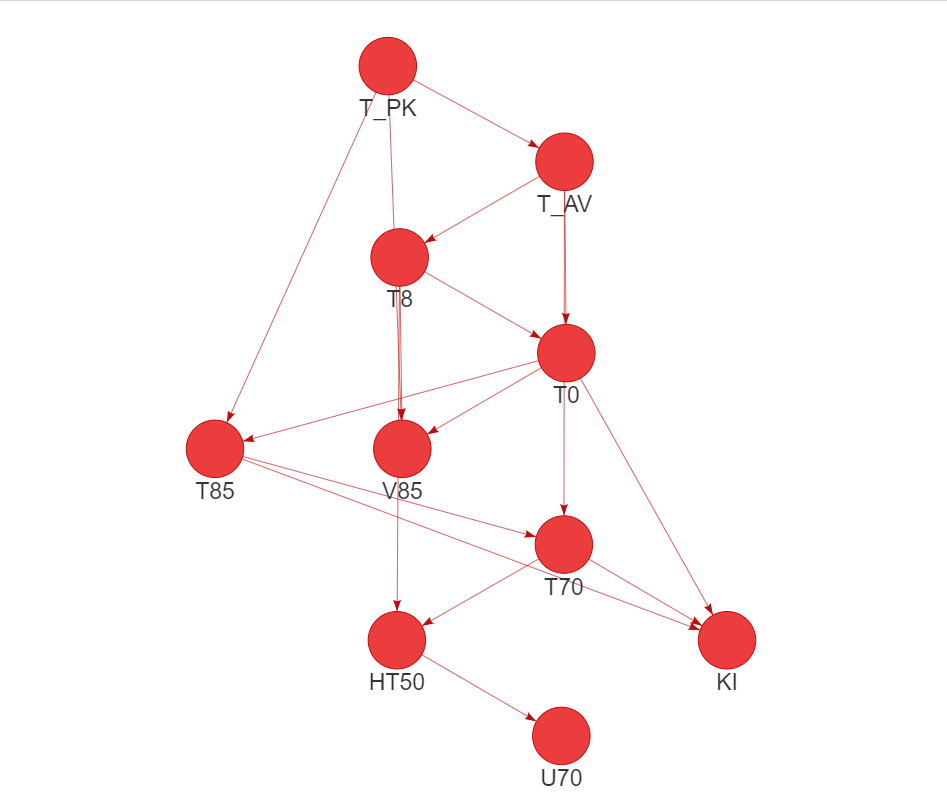

Graph of the Bayesian Network using Multidim Analysis

In [ ]:
# BayesianNetwork 

save_structure(bn, 'subsample_net_structure_mv')
skel = read_structure('subsample_net_structure_mv')
save_params(params_MV, 'subsample_net_param_mv')
params = read_params('subsample_net_param_mv')
subs_bn = HyBayesianNetwork(skel, params)

In [ ]:
# generating data using created BN MV

synth_df = generate_synthetics(subs_bn, nodes_sign, 'mix', N_samples)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, "'T0' using BN multivar analysis")

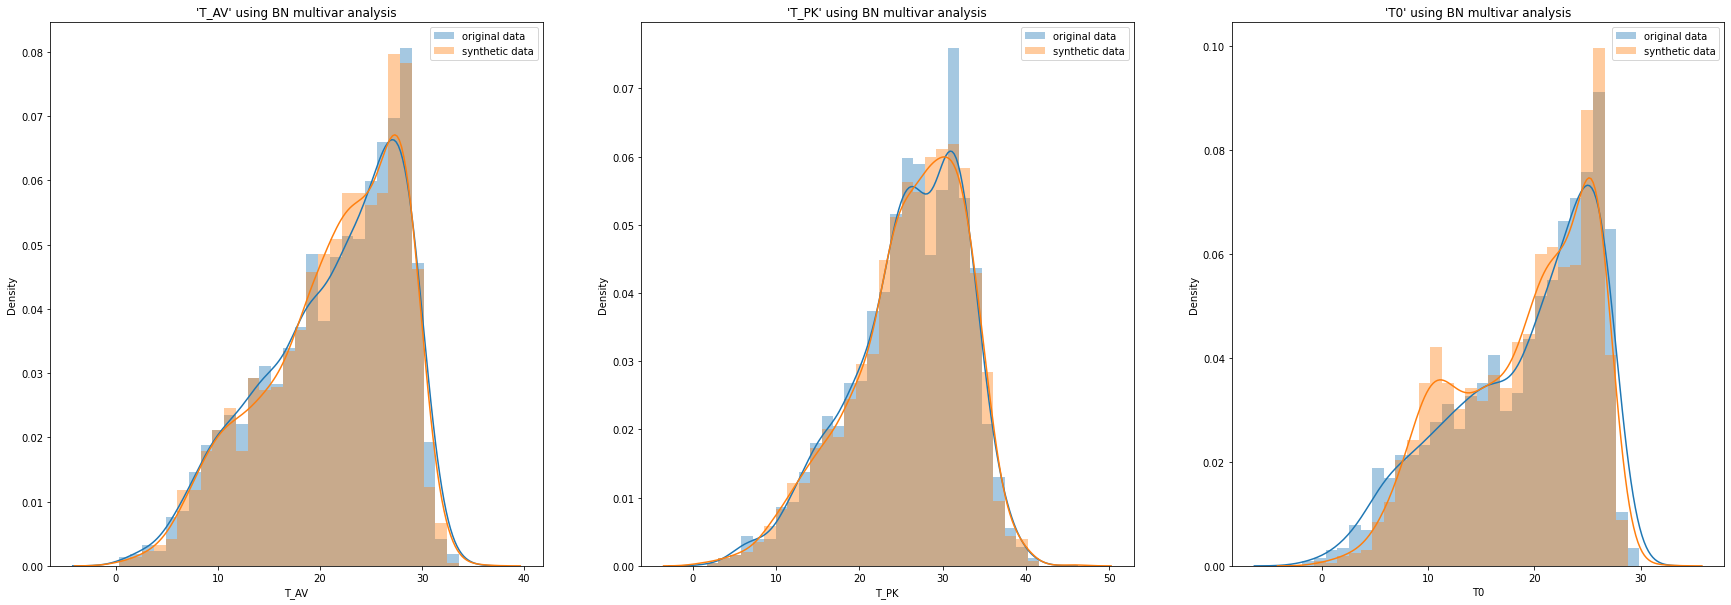

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

sns.distplot(subsample['T_AV'], x_1, ax=axes[0], label='original data')
sns.distplot(synth_df['T_AV'], x_1, ax=axes[0], label='synthetic data')
axes[0].legend(loc='best')
axes[0].set_title('\'T_AV\' using BN multivar analysis')

sns.distplot(subsample['T_PK'], x_2, ax=axes[1], label='original data')
sns.distplot(synth_df['T_PK'], x_2, ax=axes[1], label='synthetic data')
axes[1].legend(loc='best')
axes[1].set_title('\'T_PK\' using BN multivar analysis')

sns.distplot(subsample['T0'], x_3, ax=axes[2], label='original data')
sns.distplot(synth_df['T0'], x_3, ax=axes[2], label='synthetic data')
axes[2].legend(loc='best')
axes[2].set_title('\'T0\' using BN multivar analysis')


# **Step 5. Building a Bayesian network for the same set of variables using 2 algorithms for structural learning.**

In [ ]:
nodes_type = get_nodes_type(subsample)
nodes_sign = get_nodes_sign(subsample)
discrete_data, coder = discretization(subsample, 'equal_frequency', subsample_names)

In [ ]:
bn = structure_learning(discrete_data, 'HC', nodes_type, 'K2')

Graph of BN made by structure learning (HC and K2)

In [ ]:
graph_html = draw_BN(bn1=bn, node_type=nodes_type, name='Structural learning BN by HC and K2')
graph_html

Output graph
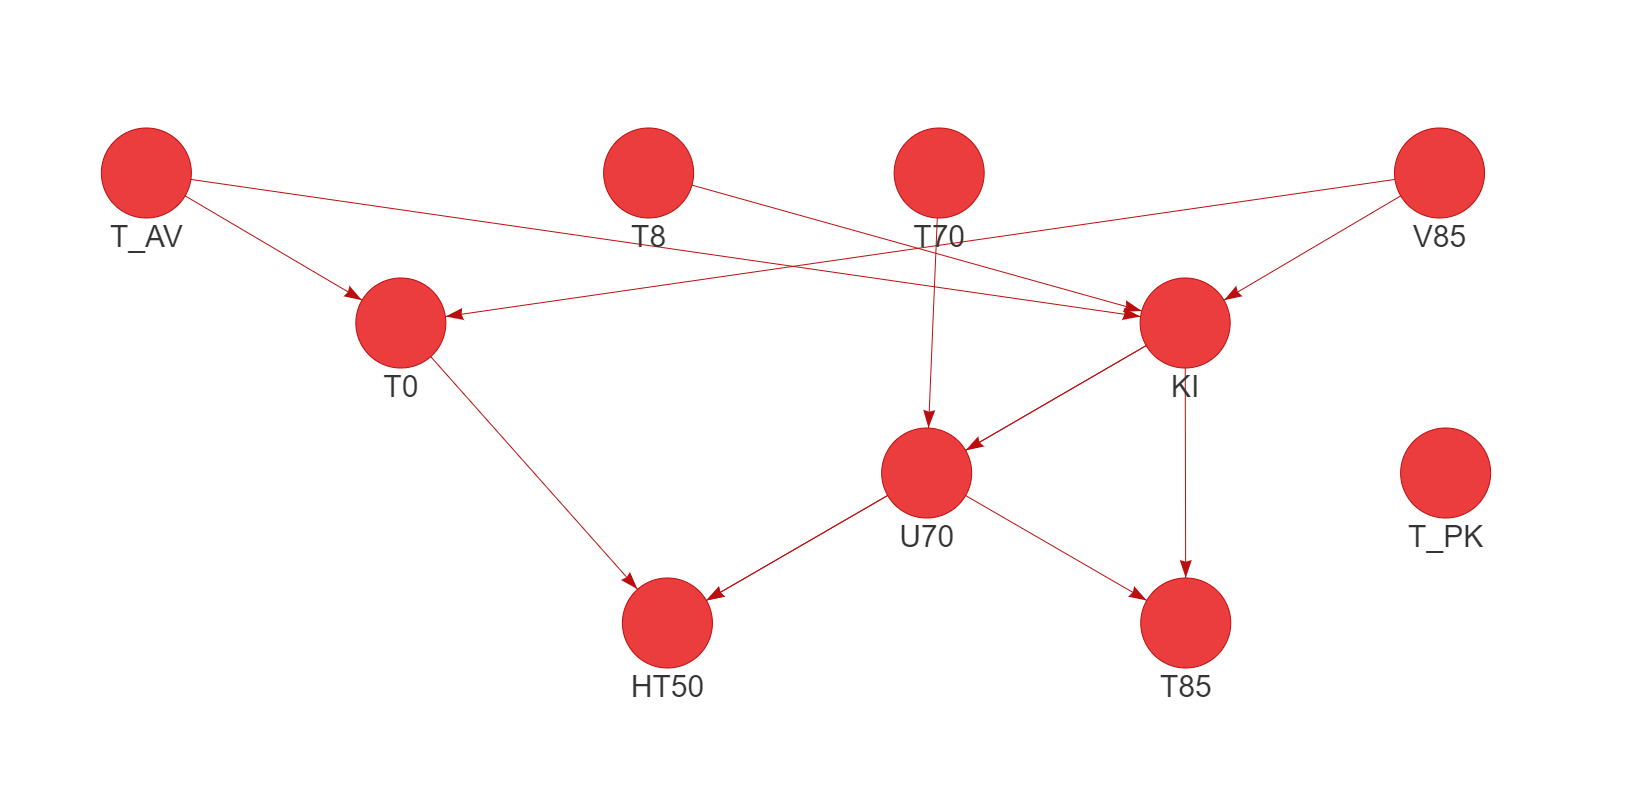

In [ ]:
bn_2 = structure_learning(discrete_data, 'evo', nodes_type, 'MI')
bn_2

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


Best metric is 9.4847
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.1 min
Best metric is 9.4847
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 0.2 min
Best metric is 9.336400000000001
Generation num: 2
max_depth: 6, no improvements: 0
spent time: 0.3 min
Best metric is 9.297999999999998
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 0.3 min
Best metric is 8.927899999999998
Generation num: 4
max_depth: 6, no improvements: 0
spent time: 0.4 min
Best metric is 8.927899999999998
Generation num: 5
max_depth: 6, no improvements: 1
spent time: 0.5 min
Best metric is 8.7655
Generation num: 6
max_depth: 6, no improvements: 0
spent time: 0.6 min
Best metric is 8.7655
Generation num: 7
max_depth: 6, no improvements: 1
spent time: 0.6 min
Best metric is 8.7655
Generation num: 8
max_depth: 6, no improvements: 2
spent time: 0.7 min
Best metric is 8.677599999999998
Generation num: 9
max_depth: 6, no improvements: 0
spent time: 0.8 min
Best metric is 

{'V': ['T85', 'T_PK', 'T_AV', 'T0', 'U70', 'HT50', 'T8', 'T70', 'V85', 'KI'],
 'E': [['U70', 'T85'],
  ['U70', 'HT50'],
  ['T0', 'HT50'],
  ['KI', 'T85'],
  ['KI', 'HT50'],
  ['KI', 'U70'],
  ['T70', 'U70'],
  ['V85', 'T0'],
  ['V85', 'KI'],
  ['T_AV', 'T0'],
  ['T_AV', 'KI'],
  ['T8', 'KI']]}

Graph of BN made by structure learning (evo and MI)

In [ ]:
graph_html_2 = draw_BN(bn1=bn_2, node_type=nodes_type, name='Structural learning BN by evo and MI')
graph_html_2

Output graph

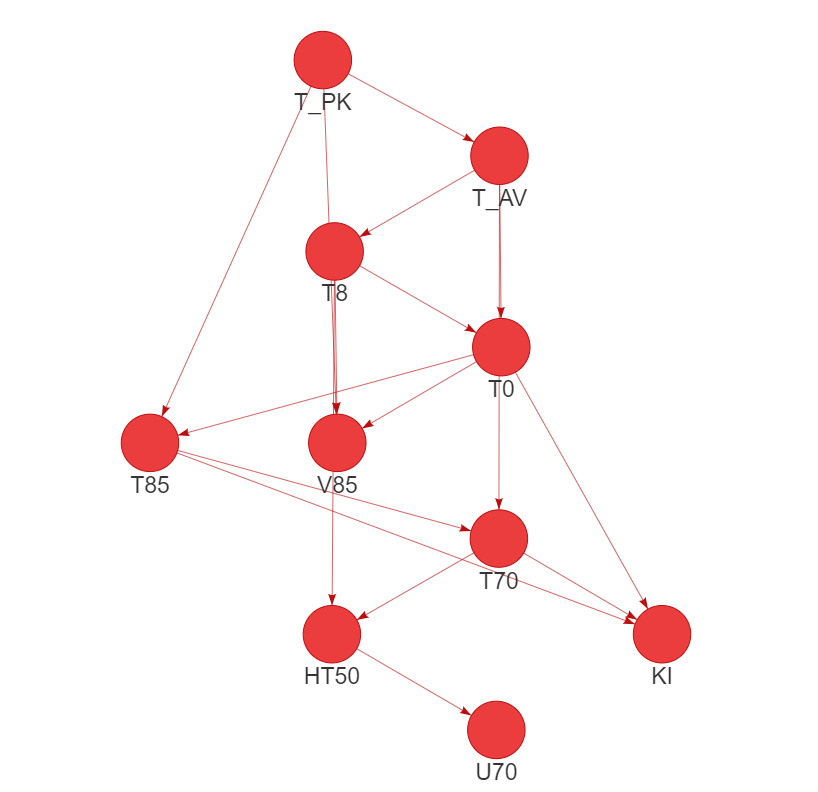

In [ ]:
# param learning
params_1 = parameter_learning(subsample, nodes_type, bn, 'mix')
params_2 = parameter_learning(subsample, nodes_type, bn_2, 'mix')

In [ ]:
# HyBayesianNetwork 1

save_structure(bn, 'subsample_net_structure')
skel = read_structure('subsample_net_structure')
save_params(params_1, 'subsample_net_param')
params_1 = read_params('subsample_net_param')
subs_bn = HyBayesianNetwork(skel, params_1)

In [ ]:
# HyBayesianNetwork 2

save_structure(bn_2, 'subsample_net_structure_2')
skel_2 = read_structure('subsample_net_structure_2')
save_params(params_2, 'subsample_net_param_2')
params_2 = read_params('subsample_net_param_2')
subs_bn_2 = HyBayesianNetwork(skel_2, params_2)

In [ ]:
# generating synthetic data using created BN 1

synth_df = generate_synthetics(subs_bn, nodes_sign, 'mix', N_samples)

In [ ]:
# generating synthetic data using created BN 2

synth_df_2 = generate_synthetics(subs_bn_2, nodes_sign, 'mix', N_samples)

# **Step 6. Analyzing quality of sampled target variables from the point of view of synthetic generation**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, "'T0' using BN_2 by evo and MI")

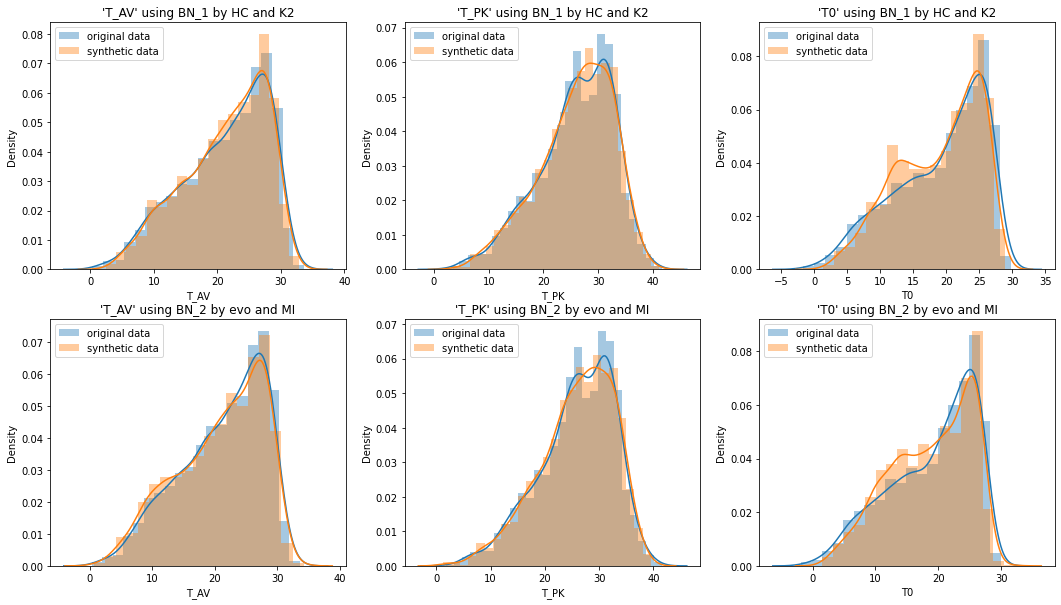

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.distplot(subsample['T_AV'], ax=axes[0,0], label='original data')
sns.distplot(synth_df['T_AV'], ax=axes[0,0], label='synthetic data')
axes[0,0].legend(loc='best')
axes[0,0].set_title('\'T_AV\' using BN_1 by HC and K2')

sns.distplot(subsample['T_PK'], ax=axes[0,1], label='original data')
sns.distplot(synth_df['T_PK'], ax=axes[0,1], label='synthetic data')
axes[0,1].legend(loc='best')
axes[0,1].set_title('\'T_PK\' using BN_1 by HC and K2')

sns.distplot(subsample['T0'], ax=axes[0,2], label='original data')
sns.distplot(synth_df['T0'], ax=axes[0,2], label='synthetic data')
axes[0,2].legend(loc='best')
axes[0,2].set_title('\'T0\' using BN_1 by HC and K2')


sns.distplot(subsample['T_AV'], ax=axes[1,0], label='original data')
sns.distplot(synth_df_2['T_AV'], ax=axes[1,0], label='synthetic data')
axes[1,0].legend(loc='best')
axes[1,0].set_title('\'T_AV\' using BN_2 by evo and MI')

sns.distplot(subsample['T_PK'], ax=axes[1,1], label='original data')
sns.distplot(synth_df_2['T_PK'], ax=axes[1,1], label='synthetic data')
axes[1,1].legend(loc='best')
axes[1,1].set_title('\'T_PK\' using BN_2 by evo and MI')

sns.distplot(subsample['T0'], ax=axes[1,2], label='original data')
sns.distplot(synth_df_2['T0'], ax=axes[1,2], label='synthetic data')
axes[1,2].legend(loc='best')
axes[1,2].set_title('\'T0\' using BN_2 by evo and MI')